# Finetuning SemSim Model

### Imports

In [1]:
import numpy as np
import umap    
import umap.plot
import torch
from torch.utils.data import DataLoader

from pathlib import Path
import numpy as np
import pandas as pd
import sentence_transformers.losses as losses
from sentence_transformers import SentenceTransformer, SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from datasets import Dataset
import sys
import os
import logging
import re

SCRIPT_DIR = Path.cwd().parent
sys.path.insert(0, str(SCRIPT_DIR))

from embeddings.embedding_library import EmbeddingLibrary

c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarn

### Init Model & Embedding Library

In [2]:
path_to_papers = Path(r'../data/paper_texts')
path_to_embs = Path(r'../data/embeddings')

# should all be lower case
end_of_paper_words = [
    'references',
    'acknowledgement', 
    'appendix',
]

papers_to_skip = [
    '2311.11329v2_content.txt',
    '2411.09324v2_content.txt',
    '2411.14259v1_content.txt',
    '2309.01837v3_content.txt'
    #'2403.12778v2_content.txt' 
]

In [3]:
model_name = 'all-distilroberta-v1'
device = 'cuda'

In [4]:
model = SentenceTransformer(model_name, device=device)

# https://huggingface.co/sentence-transformers/all-distilroberta-v1

In [ ]:
path_to_weights = r'C:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\scholarly-search\weights\semsim'

model = SentenceTransformer(path_to_weights, device=device)

In [5]:
emb_lib = EmbeddingLibrary(
    path_to_papers=path_to_papers,
    path_to_embs=path_to_embs,
    model=model,
    end_of_paper_words=end_of_paper_words,
    papers_to_skip=papers_to_skip,
    norm_embs=True,
    name=model_name,
    log_lvl=logging.INFO,
    path_to_log=Path("../log")
)

In [6]:
emb_lib.embed_papers(skip_existing=False)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


### Test Embedding Lib

In [7]:
np.load(path_to_embs/'2411.14427v1.npy').shape

(1, 768)

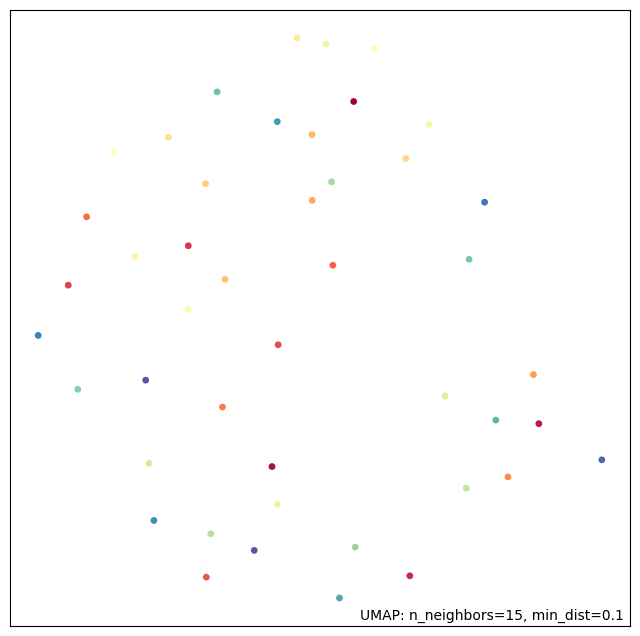

In [8]:
mapper = umap.UMAP().fit(emb_lib.paper_embs)
p = umap.plot.points(mapper, labels=pd.Series([i for i in range(emb_lib.paper_embs.shape[0])]), show_legend=False)
umap.plot.show(p)

In [9]:
model.similarity(emb_lib.paper_embs, emb_lib.paper_embs)

tensor([[1.0000, 0.3841, 0.3510,  ..., 0.5426, 0.3374, 0.3162],
        [0.3841, 1.0000, 0.3399,  ..., 0.3466, 0.4973, 0.3639],
        [0.3510, 0.3399, 1.0000,  ..., 0.6894, 0.2107, 0.3106],
        ...,
        [0.5426, 0.3466, 0.6894,  ..., 1.0000, 0.3382, 0.3323],
        [0.3374, 0.4973, 0.2107,  ..., 0.3382, 1.0000, 0.2821],
        [0.3162, 0.3639, 0.3106,  ..., 0.3323, 0.2821, 1.0000]])

In [10]:
# Paper: 2311.00207v3

prompt = ""
response = '''SECTION: IIntroduction

Next-generation (NextG) networks promise to support ultra-reliable and low-latency communication for rapidly evolving wireless devices[29]. Emerging networks are thus challenged to establish new features (e.g., adaptive coding and enhanced modulation) to overcome rapidly changing channel conditions and to achieve more efficient use of spectrum[102,63].
Machine Learning (ML) overcomes this barrier by revolutionizing the entire wireless network protocol stack[67].'''

emb_lib.search_papers(prompt, response)

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


['2311.00207v3',
 '2407.05941v4',
 '2411.13037v1',
 '2406.08298v5',
 '2411.09101v1']

In [11]:
# from 2411.06091

prompt = ""
response = '''Remote sensing technology, employing aerial or satellite platforms, facilitates the acquisition of earth observation data from afar, marking its utility across diverse sectors such as agriculture monitoring, environmental surveillance evaluation, urban planning, and disaster management. At the heart of these applications lies the interpretation of remote sensing imagery, a task that has been considerably challenging[1]. The advent of deep learning technology[2]has significantly enhanced the precision and automation of remote sensing image analysis, encompassing object detection, land cover classification, and change detection. Nonetheless, the intrinsic complexity of remote sensing scenarios—attributable to variations in sensor technology, atmospheric conditions, and image resolution—results in the performance disparity of analytical models across different contexts. The prohibitive costs associated with manual annotation further exacerbate this issue, rendering the re-labeling of samples for specific scenarios impractical. Consequently, there is a growing demand for models endowed with superior generalization capabilities, capable of adeptly navigating the multifaceted landscape of remote sensing applications.

Seeking a method that discerns both the semantic information of different scene images and the semantic details within each area of the images is essential for effectively processing scenographic remote sensing imagery. It has been observed that scenographic images in remote sensing typically exhibit specific distribution patterns, where natural elements (such as mountains, bodies of water, forests, lakes, and grasslands) and man-made elements (such as buildings, farmlands, plowed lands, and gardens) often display pronounced clustering. This tendency for feature aggregation leads to the formation of discernible geographic pattern clusters among individual image patches and their neighbors, thereby establishing intricate spatial relationships across the varying patches and their adjacent areas.'''

emb_lib.search_papers(prompt, response)

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


['2411.06091v1',
 '2411.14354v1',
 '2411.09420v1',
 '2411.09101v1',
 '2308.07279v2']

**These results are sub-par**

### Finetuning

In [12]:
# create paper chunks and Dataset

paper_chunks = []

for paper_path in emb_lib.paper_paths:
    with open(paper_path, 'r', encoding='utf-8') as p:
        paper = p.read()
        title, chunks = emb_lib.preprocess_paper(paper)
        paper_chunks.extend(chunks)
        paper_chunks.append(title)

dataset = Dataset.from_dict({
    "anchor": paper_chunks,
    "positive": paper_chunks,
})

In [ ]:
train_

In [13]:
# train a tokenizer

batch_size = 1000
all_texts = np.random.shuffle([dataset[i : i + batch_size]["anchor"] for i in range(0, len(dataset), batch_size)])

def batch_iterator():
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["anchor"]

model.tokenizer = model.tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=55000)

In [14]:
# set dropout in model

from torch.nn.modules.dropout import Dropout

def set_dropout(model, p):

    def set_d(module):
        for c in module.children():
            if len(list(module.children())) == 0: return
            if isinstance(c, Dropout):
                c.p = p
            set_d(c)

    for m in model.modules():
        set_d(m)

set_dropout(model, 0.5)   

In [15]:
# Use the MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)

args = SentenceTransformerTrainingArguments(
    output_dir=f"training/{model_name}",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    #per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if your GPU can't handle FP16
    bf16=False,  # Set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # Losses using "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    # eval_strategy="steps",
    # eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=f"{model_name}",  # Used in W&B if `wandb` is installed
)



In [30]:
trainer = SentenceTransformerTrainer(
    model = model,
    args = args,
    train_dataset = dataset,
    loss = train_loss,
    tokenizer = model.tokenizer,  
)
trainer.train()

In [31]:
path_to_weights = r'C:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\scholarly-search\weights\semsim'
model.save(path_to_weights)

                                                  
 34%|███▎      | 518/1535 [05:09<05:38,  3.01it/s]

{'loss': 0.454, 'grad_norm': 5.565038204193115, 'learning_rate': 3.14935064935065e-05, 'epoch': 0.33}




                                                  
 34%|███▎      | 518/1535 [06:17<05:38,  3.01it/s]

{'loss': 0.0543, 'grad_norm': 3.9539802074432373, 'learning_rate': 4.844315713251267e-05, 'epoch': 0.65}


                                                  
 34%|███▎      | 518/1535 [06:59<05:38,  3.01it/s]

{'loss': 0.0377, 'grad_norm': 0.3020555377006531, 'learning_rate': 4.4822592324402606e-05, 'epoch': 0.98}


                                                  
 34%|███▎      | 518/1535 [07:50<05:38,  3.01it/s]

{'loss': 0.0253, 'grad_norm': 0.2598021626472473, 'learning_rate': 4.1202027516292545e-05, 'epoch': 1.3}


                                                  
 34%|███▎      | 518/1535 [08:58<05:38,  3.01it/s]

{'loss': 0.0087, 'grad_norm': 0.3064405024051666, 'learning_rate': 3.758146270818248e-05, 'epoch': 1.63}


                                                  
 34%|███▎      | 518/1535 [09:40<05:38,  3.01it/s]

{'loss': 0.0179, 'grad_norm': 0.1715710610151291, 'learning_rate': 3.3960897900072416e-05, 'epoch': 1.95}


                                                  
 34%|███▎      | 518/1535 [10:30<05:38,  3.01it/s]

{'loss': 0.0134, 'grad_norm': 0.22755272686481476, 'learning_rate': 3.034033309196235e-05, 'epoch': 2.28}


                                                  
 34%|███▎      | 518/1535 [11:42<05:38,  3.01it/s]

{'loss': 0.0056, 'grad_norm': 0.04436185956001282, 'learning_rate': 2.671976828385228e-05, 'epoch': 2.61}


                                                  
 34%|███▎      | 518/1535 [12:24<05:38,  3.01it/s]

{'loss': 0.0088, 'grad_norm': 4.521520614624023, 'learning_rate': 2.3099203475742217e-05, 'epoch': 2.93}


                                                  
 34%|███▎      | 518/1535 [13:10<05:38,  3.01it/s] 

{'loss': 0.012, 'grad_norm': 0.3633098006248474, 'learning_rate': 1.9478638667632152e-05, 'epoch': 3.26}


                                                  
 34%|███▎      | 518/1535 [14:24<05:38,  3.01it/s] 

{'loss': 0.0034, 'grad_norm': 0.2215462327003479, 'learning_rate': 1.5858073859522085e-05, 'epoch': 3.58}


                                                  
 34%|███▎      | 518/1535 [15:06<05:38,  3.01it/s] 

{'loss': 0.0068, 'grad_norm': 0.11929313838481903, 'learning_rate': 1.223750905141202e-05, 'epoch': 3.91}


                                                  
 34%|███▎      | 518/1535 [15:52<05:38,  3.01it/s] 

{'loss': 0.0089, 'grad_norm': 0.25609907507896423, 'learning_rate': 8.616944243301955e-06, 'epoch': 4.23}


                                                  
 34%|███▎      | 518/1535 [17:07<05:38,  3.01it/s] 

{'loss': 0.0036, 'grad_norm': 0.027053426951169968, 'learning_rate': 4.99637943519189e-06, 'epoch': 4.56}


                                                  
 34%|███▎      | 518/1535 [17:48<05:38,  3.01it/s] 

{'loss': 0.0063, 'grad_norm': 1.005142092704773, 'learning_rate': 1.3758146270818247e-06, 'epoch': 4.89}


                                                  
100%|██████████| 1535/1535 [13:45<00:00,  1.86it/s]

{'train_runtime': 825.2674, 'train_samples_per_second': 29.706, 'train_steps_per_second': 1.86, 'train_loss': 0.04364390678048522, 'epoch': 5.0}


TrainOutput(global_step=1535, training_loss=0.04364390678048522, metrics={'train_runtime': 825.2674, 'train_samples_per_second': 29.706, 'train_steps_per_second': 1.86, 'total_flos': 0.0, 'train_loss': 0.04364390678048522, 'epoch': 5.0})